# BermudanSwaption.jl

In this notebook, we illustrate the pricing of Bermudan swaptions with the DiffFusion.jl.

## Incorporating DiffFusion.jl

We setup a Julia project environment in the current directory.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\Users\Sebastian\01_GitHub\sschlenkrich\InterestRateDerivatives.jl`


We need to incorporate the DiffFusion package.

In [2]:
using DiffFusion

And use some further packages.

In [3]:
using Plots

## Model Setup

For this example, we set up a one-factor Gaussian HJM model.

The model requires various inputs.

### Correlations

Correlations between risk factors are stored in a `CorrelationHolder` object.

A one-factor interest rate model does not need need correlations. But the model interface requires that input. Therefore, we set up a trivial correlation holder without correlation values.

In [4]:
ch = DiffFusion.correlation_holder("");

### Benchmark Rates

The volatility specification of the HJM model uses *benchmark rates*. The benchmark rates are parametrised by tenors $\delta$.

For the one-factor model we choose the short rate as our benchmark rate. The corresponding tenor is zero.

In [5]:
δ = DiffFusion.flat_parameter([ 0., ]);

### Mean Reversion Parameter

We need to specify a constant mean reversion rate per yield curve factor. For our one-factor model this is just a single value.

In [6]:
χ = DiffFusion.flat_parameter([ 0.01, ]);

### Volatility

We use a piece-wise constant volatility function.

In [7]:
times = [  1.,  2.,  5., 10. ]
values = [ 50.,  60.,  70.,  80., ]' * 1.0e-4 
σ = DiffFusion.backward_flat_volatility("", times, values);

### Model

In the model, we combine the various parameters.

In [8]:
model = DiffFusion.gaussian_hjm_model("md/EUR", δ, χ, σ, ch, nothing);

## Monte Carlo Simulation

For a given model, we can now simulate state variables. The MC simulation is specified by simulation times and number of MC paths.

In this example, we use Sobol sequences as quasi-random numbers.

In [9]:
times = 0.0:1.0:10.0
n_paths = 2^3

sim = DiffFusion.simple_simulation(
    model,
    ch,
    times,
    n_paths,
    with_progress_bar = false,
    brownian_increments = DiffFusion.sobol_brownian_increments,
);

We can inspect the simulated state variables. Data is stored in the `X` element of the simulation.

The variable `X` is a 3-dim array of size `(n_states, n_paths, n_times)`.

Number of states `n_states` are specified by the model.

In [10]:
DiffFusion.state_alias(model)

2-element Vector{String}:
 "md/EUR_x_1"
 "md/EUR_s"

Number of paths `n_paths` and number of simulation times `n_times` are properties of the MC simulation.

In [11]:
size(sim.X)

(2, 8, 11)

For illustration, we plot the simulated paths of the $x$ variable.

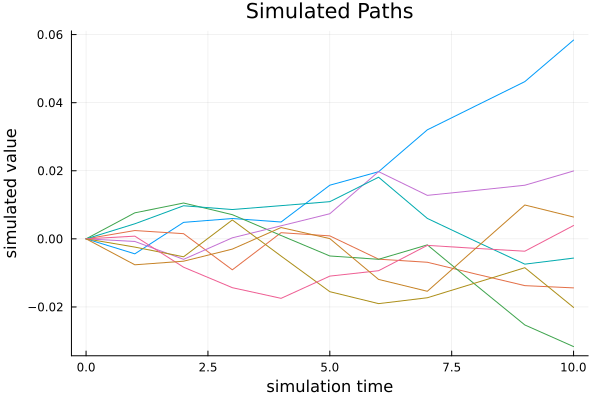

In [12]:
plot(
    times,
    sim.X[1, :, :]',
    title = "Simulated Paths",
    label = nothing,
    xlabel = "simulation time",
    ylabel = "simulated value",
)

## Term Structures, Context and Path

To use a simulation for pricing we need to link market data, model, simulation and products.

This step is realised by a `Context` object and a `Path` object.

As a first step, we define curves that we need for pricing.

We keep things simple for this example and only use a discount and projection yield curve.

In [13]:
yc_estr = DiffFusion.zero_curve(
    "yc/EUR:ESTR",
    [1.0, 3.0, 6.0, 10.0],
    [1.0, 1.0, 1.0,  1.0] .* 1e-2,
)
yc_euribor6m = DiffFusion.zero_curve(
    "yc/EUR:EURIBOR6M",
    [1.0, 3.0, 6.0, 10.0],
    [2.0, 2.0, 2.0,  2.0] .* 1e-2,
)

ts_list = [
    yc_estr,
    yc_euribor6m,
];

The `Context` links the *keys* in the products to the *aliases* of models and term structures.

In [14]:
_empty_key = DiffFusion._empty_context_key
context = DiffFusion.Context(
    "Std",
    DiffFusion.NumeraireEntry("EUR", "md/EUR", Dict(_empty_key => "yc/EUR:ESTR")),
    Dict{String, DiffFusion.RatesEntry}([
        ("EUR", DiffFusion.RatesEntry("EUR", "md/EUR", Dict(
            _empty_key  => "yc/EUR:ESTR",
            "ESTR"      => "yc/EUR:ESTR",
            "EURIBOR6M" => "yc/EUR:EURIBOR6M",
        ))),
    ]),
    Dict{String, DiffFusion.AssetEntry}(),
    Dict{String, DiffFusion.ForwardIndexEntry}(),
    Dict{String, DiffFusion.FutureIndexEntry}(),
    Dict{String, DiffFusion.FixingEntry}(),
);

The `Path` combines the various components involves.

In [15]:
path = DiffFusion.path(sim, ts_list, context, DiffFusion.LinearPathInterpolation);

## Product Setup

We illustrate product setup in three steps:

1. Cash flows and Vanilla swap.

2. Co-terminal European swaptions.

3. Bermudan swaption.


### Cash Flows and Vanilla Swap

We use a spot-starting 10y Vanilla swap exchanging 6m Euribor versus fixes as our example instrument.

(To keep things simple, we omit spot lag and fixing lag in this example.)

In a first step, we need to specify the fixed and floating rate cash flows.

In [16]:
fixed_flows = [
    DiffFusion.FixedRateCoupon( 1.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 2.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 3.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 4.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 5.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 6.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 7.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 8.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon( 9.0, 0.02, 1.0),
    DiffFusion.FixedRateCoupon(10.0, 0.02, 1.0),
];

libor_flows = [
    DiffFusion.SimpleRateCoupon(0.0, 0.0, 0.5, 0.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(0.5, 0.5, 1.0, 1.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(1.0, 1.0, 1.5, 1.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(1.5, 1.5, 2.0, 2.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(2.0, 2.0, 2.5, 2.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(2.5, 2.5, 3.0, 3.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(3.0, 3.0, 3.5, 3.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(3.5, 3.5, 4.0, 4.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(4.0, 4.0, 4.5, 4.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(4.5, 4.5, 5.0, 5.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(5.0, 5.0, 5.5, 5.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(5.5, 5.5, 6.0, 6.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(6.0, 6.0, 6.5, 6.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(6.5, 6.5, 7.0, 7.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(7.0, 7.0, 7.5, 7.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(7.5, 7.5, 8.0, 8.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(8.0, 8.0, 8.5, 8.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(8.5, 8.5, 9.0, 9.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(9.0, 9.0, 9.5, 9.5, 0.5, "EUR:EURIBOR6M", nothing, nothing),
    DiffFusion.SimpleRateCoupon(9.5, 9.5, 10.0, 10.0, 0.5, "EUR:EURIBOR6M", nothing, nothing),
];

Cash flows are combined into cash flow legs.

Cash flow legs decorate cash flows with details about notional, discounting, FX conversion and payer vs. receiver.

In [17]:
fixed_notionals = 10_000.00 * ones(length(fixed_flows))
fixed_leg = DiffFusion.cashflow_leg(
    "leg/1", fixed_flows, fixed_notionals, "EUR:ESTR", nothing,  1.0,
)

float_notionals = 10_000.00 * ones(length(libor_flows))
float_leg = DiffFusion.cashflow_leg(
    "leg/2", libor_flows, float_notionals, "EUR:ESTR", nothing,  -1.0
);

A Vanilla swap is the just a collection of cash flow legs.

In [18]:
vanilla_swap = [ fixed_leg, float_leg ]

2-element Vector{DiffFusion.DeterministicCashFlowLeg}:
 DiffFusion.DeterministicCashFlowLeg("leg_1", DiffFusion.FixedRateCoupon[DiffFusion.FixedRateCoupon(1.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(2.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(3.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(4.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(5.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(6.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(7.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(8.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(9.0, 0.02, 1.0), DiffFusion.FixedRateCoupon(10.0, 0.02, 1.0)], [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0], "EUR:ESTR", nothing, 1.0)
 DiffFusion.DeterministicCashFlowLeg("leg_2", DiffFusion.SimpleRateCoupon[DiffFusion.SimpleRateCoupon(0.0, 0.0, 0.5, 0.5, 0.5, "EUR:EURIBOR6M", nothing, nothing), DiffFusion.SimpleRateCoupon(0.5, 0.5, 1.0, 1.0, 0.5, "EUR:EURIBOR6M", nothing, nothing), DiffFusion.SimpleRateCoupon(1.0, 1.0, 1.5, 1.5, 0.5, "EUR:EU

### European Swaptions

We consider co-terminal swaptions at 2y, 4y, 6y and 8y expiries.

To simplify setup er define a short-cut function for create the swaptions.


In [19]:
payer_receiver = 1.0
swap_disc_curve_key = "EUR:OIS"
settlement_type = DiffFusion.SwaptionPhysicalSettlement
notional = 10_000.00

swpt_disc_curve_key = "EUR:ESTR"
swpt_fx_key = nothing
swpt_long_short = 1.0

make_swaption(_alias, _expiry_time, _float_coupons, _fixed_coupons, ) = DiffFusion.SwaptionLeg(
    _alias,
    _expiry_time,
    _expiry_time, # settlement_time
    _float_coupons,
    _fixed_coupons,
    payer_receiver,
    swap_disc_curve_key,
    settlement_type,
    notional,
    swpt_disc_curve_key,
    swpt_fx_key,
    swpt_long_short,
)

make_swaption (generic function with 1 method)

In [26]:
swaption_2y = make_swaption("leg/swpn/2y", 2.0, libor_flows[5:end], fixed_flows[2:end])
swaption_4y = make_swaption("leg/swpn/4y", 4.0, libor_flows[9:end], fixed_flows[4:end])
swaption_6y = make_swaption("leg/swpn/6y", 6.0, libor_flows[13:end], fixed_flows[6:end])
swaption_8y = make_swaption("leg/swpn/8y", 8.0, libor_flows[17:end], fixed_flows[8:end]);